In [1]:
# При изменениях в коде проекте эти обновления будут автоматически подгружаться в ноутбук
%load_ext autoreload
%autoreload 2

Настройка путей для импорта модулей:

In [11]:
!pip install peft==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 678.5 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0


In [12]:
!pip show peft

Name: peft
Version: 0.10.0
Summary: Parameter-Efficient Fine-Tuning (PEFT)
Home-page: https://github.com/huggingface/peft
Author: The HuggingFace team
Author-email: sourab@huggingface.co
License: Apache
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: accelerate, huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch, tqdm, transformers
Required-by: 


In [8]:
!pip install accelerate==0.31.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 725.4 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [6]:
!pip show huggingface_hub

Name: huggingface-hub
Version: 0.26.3
Summary: Client library to download and publish models, datasets and other repos on the huggingface.co hub
Home-page: https://github.com/huggingface/huggingface_hub
Author: Hugging Face, Inc.
Author-email: julien@huggingface.co
License: Apache
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: filelock, fsspec, packaging, pyyaml, requests, tqdm, typing-extensions
Required-by: accelerate, peft, tokenizers, transformers


In [15]:
!pip install detoxify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.0 MB/s eta 0:00:00a 0:00:010m


In [25]:
!pip install gdown

In [6]:
import os
import sys
import inspect
import argparse
import numpy as np
import os
os.chdir('/Users/ayagnych/Downloads/DetoxAI_NLA')
os.environ["DATASET_DIR"] = "~/Download/DetoxAI_NLA/toxicity_pairwise"
from detox import DeToxEdit
import torch

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from utils.startup import main
from evaluate_model import evaluate_model

if '__file__' in globals():
    parser = argparse.ArgumentParser(description='DeTox')
    parser.add_argument('--config_file', default='gpt2-medium.ini', type=str, help='Config Filename. E.g. gpt2-medium.ini')
    args = parser.parse_args()
    config_filename = args.config_file
else:
    config_filename = 'gpt2-medium.ini'

config = main(config_filename=config_filename)


No CUDA_VISIBLE_DEVICES found. Setting to 0.
PROJECT_ROOT: 'detox-edit'
PYTHONPATH: 'detox-edit':
HF_HOME: 'detox-edit'


Загрузка модели GPT-2 и токенизатора

In [7]:
from utils.model_utils import load_large_model
from detox import DeToxEdit

model_id = 'gpt2'
model, tokenizer = load_large_model(model_id)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

INFO:root:Model gpt2 loaded.


Слои для изменений, указанные в статье для GPT-2, как уже упомяналось, кода по определению этих границ нет, лишь небольшое текстовое описание в самой статье

In [9]:
lower_layer = 10
upper_layer = 24

layer_range = np.arange(lower_layer, upper_layer) if lower_layer != -1 and upper_layer != -1 else None

In [10]:
editor = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=300,
    centering=True,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)

In [20]:
toxicity_data_path = "/Users/ayagnych/Downloads/DetoxAI_NLA/toxicity_pairwise/split_0.jsonl"

ats, preference_matrix = editor.get_ats(data_path=toxicity_data_path)

INFO:root:Loaded 300 preferred and 300 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Centering: Removing first singular vector from preference matrix.


In [21]:
svd = editor.svd_on_ats(ats)

INFO:root:SVD of ATS calculated.


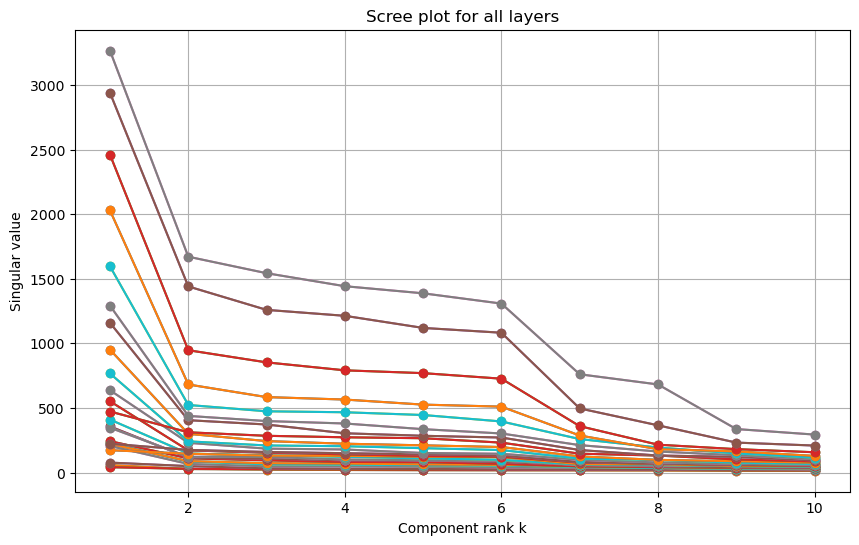

In [28]:
import matplotlib.pyplot as plt

def combined_scree_plot(svd, max_rank=10):
    plt.figure(figsize=(10, 6))

    for key in svd:
        singular_values = svd[key]['s'][:max_rank]
        plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o', label=f'Layer: {key}')

    plt.title("Scree plot for all layers")
    plt.xlabel("Component rank k")
    plt.ylabel("Singular value")
    #plt.legend()
    plt.grid(True)
    plt.show()

combined_scree_plot(svd, max_rank=10)

начиная с  k = 4, значения сингулярных чисел уменьшаются незначительно и “выравниваются” для большинства слоев. оптимальный ранг - 2 или 3 (основная информация о токсичном подпространстве содержится там)

In [29]:
!pip install screenot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
from screenot.ScreeNOT import adaptiveHardThresholding

def apply_screenot(svd_results, max_rank=10):
    """
        svd_results: результат SVD (словарь с ключами 'u', 's', 'v')
        max_rank: максимальный ранг для анализа
    """
    # восстанавливаем матрицу из сингулярных значений (Y ≈ U S V^T)
    singular_values = svd_results['s'][:max_rank]
    U = svd_results['u'][:, :max_rank]
    Vt = svd_results['v'][:max_rank, :]

    Y = U @ np.diag(singular_values) @ Vt

    Xest, Topt, r = adaptiveHardThresholding(Y, k=max_rank, strategy='i')
    return r, Xest

optimal_ranks = {}

# screeNot для каждого слоя
for key in svd:
    r, _ = apply_screenot(svd[key])
    optimal_ranks[key] = r
    print(f"Слой {key}: Оптимальный ранг = {r}")

print("\nСводка результатов ScreeNot для всех слоев:")
for key, rank in optimal_ranks.items():
    print(f"Слой {key}: ранг = {rank}")

Слой transformer.h.0.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.0.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.1.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.1.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.2.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.2.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.3.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.3.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.4.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.4.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.5.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.5.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.6.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.6.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.7.mlp.c_fc.weight: Оптимальный ранг = 10
Слой transformer.h.7.mlp.c_proj.weight: Оптимальный ранг = 10
Слой transformer.h.8.mlp

Оптимальный ранг - 10

In [66]:
def compute_norms(ats, svd_results, ranks):
    errors = {rank: {} for rank in ranks}
    
    for layer_name, original_matrix in ats.items():
        print(f"Обработка слоя: {layer_name}")
        for rank in ranks:
            # Извлекаем компоненты SVD
            U = svd_results[layer_name]['u']
            S = svd_results[layer_name]['s']
            V = svd_results[layer_name]['v']
            
            # Аппроксимируем матрицу
            S_k = torch.diag(S[:rank])
            U_k = U[:, :rank]
            V_k = V[:, :rank]
            approximated_matrix = U_k @ S_k @ V_k.T
            
            # Вычисляем нормы ошибок
            frobenius_norm = torch.norm(original_matrix - approximated_matrix, p='fro').item()
            spectral_norm = torch.norm(original_matrix - approximated_matrix, p=2).item()
            
            # Сохраняем ошибки
            errors[rank][layer_name] = {
                'frobenius_norm': frobenius_norm,
                'spectral_norm': spectral_norm
            }
            print(f"Ранг {rank}: Фробениус = {frobenius_norm:.4f}, Спектральная = {spectral_norm:.4f}")
    
    return errors

ranks = [5, 10]
errors = compute_norms(ats, svd, ranks)

# Вывод ошибок
for rank in ranks:
    print(f"\nRank {rank}:")
    for layer, error in errors[rank].items():
        print(f"Layer: {layer}, Frobenius norm: {error['frobenius_norm']:.4f}, Spectral norm: {error['spectral_norm']:.4f}")

Обработка слоя: transformer.h.0.mlp.c_fc.weight
Ранг 5: Фробениус = 86.1378, Спектральная = 86.1378
Ранг 10: Фробениус = 78.3477, Спектральная = 78.3477
Обработка слоя: transformer.h.0.mlp.c_proj.weight
Ранг 5: Фробениус = 86.1378, Спектральная = 86.1378
Ранг 10: Фробениус = 78.3477, Спектральная = 78.3477
Обработка слоя: transformer.h.1.mlp.c_fc.weight
Ранг 5: Фробениус = 104.4668, Спектральная = 104.4668
Ранг 10: Фробениус = 94.7446, Спектральная = 94.7446
Обработка слоя: transformer.h.1.mlp.c_proj.weight
Ранг 5: Фробениус = 104.4668, Спектральная = 104.4668
Ранг 10: Фробениус = 94.7446, Спектральная = 94.7446
Обработка слоя: transformer.h.2.mlp.c_fc.weight
Ранг 5: Фробениус = 118.3698, Спектральная = 118.3698
Ранг 10: Фробениус = 106.2939, Спектральная = 106.2939
Обработка слоя: transformer.h.2.mlp.c_proj.weight
Ранг 5: Фробениус = 118.3698, Спектральная = 118.3698
Ранг 10: Фробениус = 106.2939, Спектральная = 106.2939
Обработка слоя: transformer.h.3.mlp.c_fc.weight
Ранг 5: Фробениу

с одной стороны, k=5 вполне достаточно, но высокие нормы ошибок в верхних слоях показывают, что эти слои обрабатывают более сложные паттерны, требующие большего ранга для аппроксимации

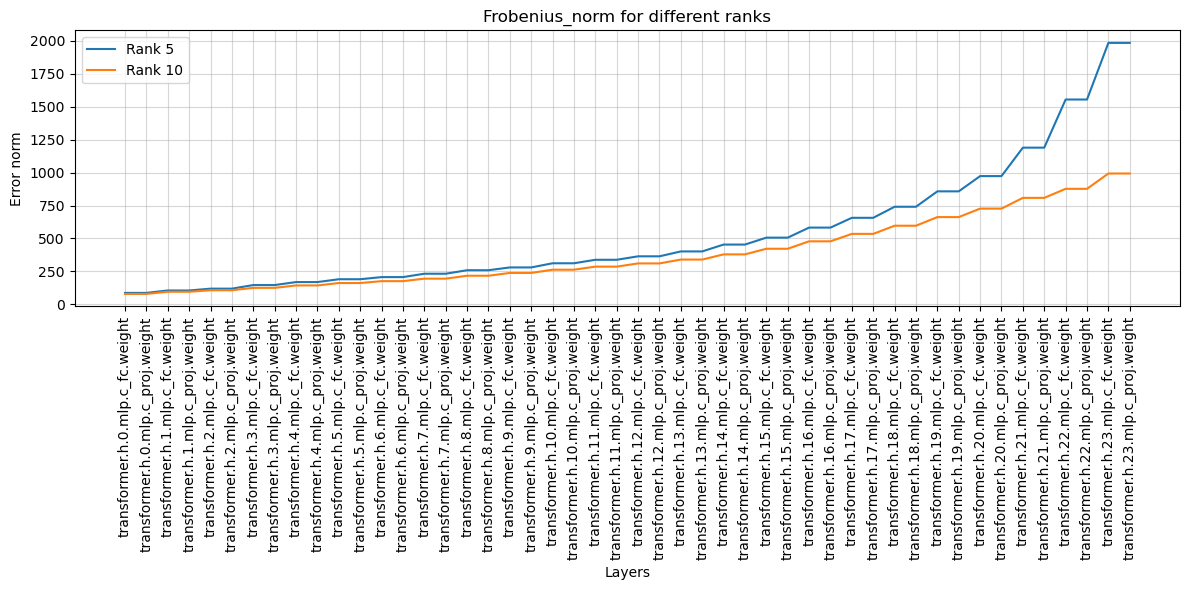

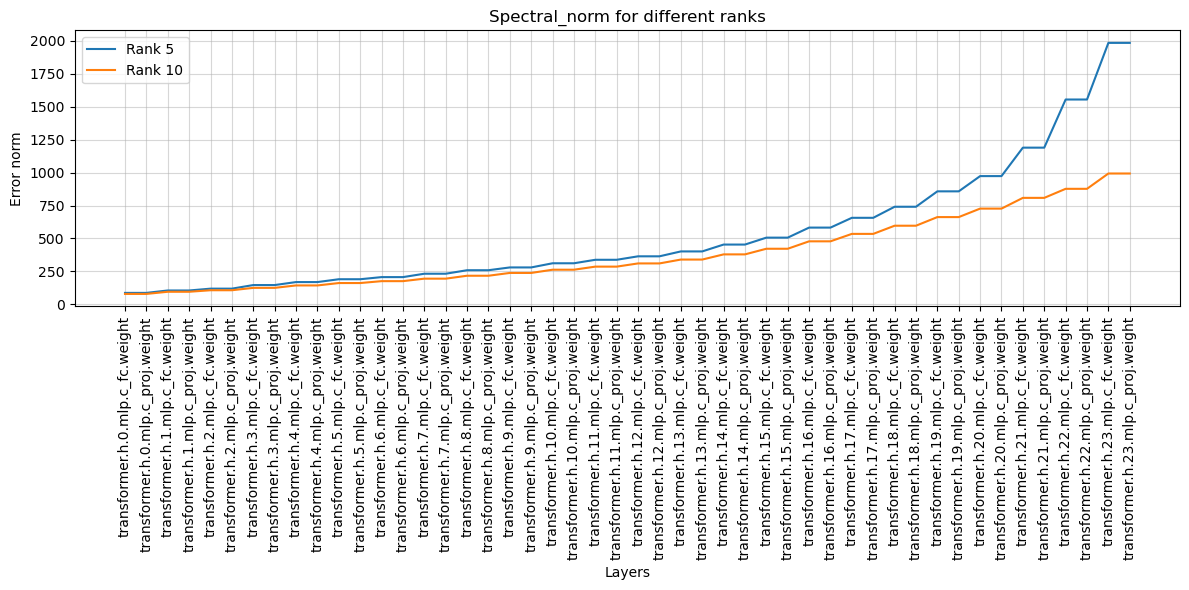

In [80]:
def plot_norms_across_layers(errors, ranks, norm_type='frobenius_norm'):
    """
    Визуализирует нормы ошибок для каждого слоя при разных рангах.
    
    Args:
        errors: Словарь с ошибками (Frobenius и Spectral norms) для каждого слоя и ранга.
        ranks: Список рангов для анализа.
        norm_type: Тип нормы ('frobenius_norm' или 'spectral_norm').
    """
    plt.figure(figsize=(12, 6))
    
    for rank in ranks:
        layers = list(errors[rank].keys())  # Названия слоёв
        norms = [errors[rank][layer][norm_type] for layer in layers]  # Соответствующие нормы
        plt.plot(layers, norms, label=f'Rank {rank}')
    
    plt.xticks(rotation=90)  # Поворот меток оси x для удобства чтения
    plt.xlabel('Layers')  # Подпись оси x
    plt.ylabel('Error norm')  # Подпись оси y
    plt.title(f'{norm_type.capitalize()} for different ranks')  # Заголовок
    plt.legend()  # Легенда
    plt.tight_layout()  # Оптимизация расположения
    plt.grid(alpha=0.5)  # Сетка
    plt.show()
    
plot_norms_across_layers(errors, ranks=[5, 10], norm_type='frobenius_norm')
plot_norms_across_layers(errors, ranks=[5, 10], norm_type='spectral_norm')

In [56]:
def recompute_svd(ats, rank):
    """
    Пересчитывает SVD для исходных матриц ATS.
    Args:
        ats: Словарь ATS (исходные матрицы).
        rank: Ранг для аппроксимации.
    Returns:
        svd_results: Словарь с пересчитанным SVD.
    """
    svd_results = {}
    for layer_name, matrix in ats.items():
        print(f"Recomputing SVD for layer: {layer_name}")
        # Приводим матрицу к float32 (требование torch.linalg.svd)
        matrix = matrix.to(torch.float32)
        
        # Выполняем SVD
        U, S, V = torch.linalg.svd(matrix, full_matrices=False)
        
        # Сохраняем только необходимые компоненты
        svd_results[layer_name] = {
            'u': U[:, :rank],
            's': S[:rank],
            'v': V[:, :rank]
        }
    
    return svd_results

# Пример использования:
rank_to_recompute = 300  # Используем максимальный ранг для SVD
svd_results_recomputed = recompute_svd(ats, rank_to_recompute)

Recomputing SVD for layer: transformer.h.0.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.0.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h.1.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.1.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h.2.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.2.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h.3.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.3.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h.4.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.4.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h.5.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.5.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h.6.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.6.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h.7.mlp.c_fc.weight
Recomputing SVD for layer: transformer.h.7.mlp.c_proj.weight
Recomputing SVD for layer: transformer.h

In [77]:
def evaluate_toxicity_with_custom_ats(model, tokenizer, approximated_ats, evaluate_fn):
    """
    Оценивает токсичность модели с аппроксимированными ATS.
    
    Args:
        model: GPT-2 модель.
        tokenizer: Токенизатор модели.
        approximated_ats: Словарь с аппроксимированными ATS для текущего ранга.
        evaluate_fn: Функция для оценки токсичности.
        
    Returns:
        Токсичность модели.
    """
    # Здесь можно добавить кастомную логику для активаций
    print("Evaluating model with approximated ATS...")

    # Вызываем функцию оценки модели
    ppl, tox = evaluate_fn(
        model=model,
        tokenizer=tokenizer,
        return_toxicity=True,
        return_perplexity=False,
        display_gen=False
    )

    return tox

def generate_approximated_ats_for_ranks(ats, svd_results, ranks):
    """
    Генерирует аппроксимированные ATS для всех указанных рангов.
    
    Args:
        ats: Исходные ATS матрицы.
        svd_results: Результаты SVD (содержат 'u', 's', 'v').
        ranks: Список рангов для аппроксимации.
        
    Returns:
        approximated_ats_all: Словарь с аппроксимированными ATS для каждого ранга.
    """
    approximated_ats_all = {}
    for rank in ranks:
        approximated_ats = {}
        for layer_name, svd_data in svd_results.items():
            U, S, V = svd_data['u'], svd_data['s'], svd_data['v']
            S_k = torch.diag(S[:rank])
            U_k = U[:, :rank]
            V_k = V[:, :rank]
            approximated_matrix = U_k @ S_k @ V_k.T
            approximated_ats[layer_name] = approximated_matrix
        approximated_ats_all[rank] = approximated_ats
    return approximated_ats_all

def evaluate_toxicity_for_ranks(model, tokenizer, ats, ranks, svd_fn, evaluate_fn):
    """
    Оценивает токсичность модели для аппроксимированных ATS при различных рангах.
    
    Args:
        model: GPT-2 модель.
        tokenizer: Токенизатор модели.
        ats: Исходные ATS матрицы.
        ranks: Список рангов для анализа.
        svd_fn: Функция для вычисления SVD.
        evaluate_fn: Функция для оценки токсичности.
        
    Returns:
        toxicity_results: Словарь с результатами токсичности для каждого ранга.
    """
    print("Calculating SVD for ATS...")
    svd_results = svd_fn(ats)  # Вычисление SVD для ATS
    
    print("Generating approximated ATS for ranks...")
    approximated_ats_all = generate_approximated_ats_for_ranks(ats, svd_results, ranks)
    
    toxicity_results = {}
    for rank, approximated_ats in approximated_ats_all.items():
        print(f"Evaluating toxicity for rank k={rank}...")
        toxicity = evaluate_toxicity_with_custom_ats(model, tokenizer, approximated_ats, evaluate_fn)
        toxicity_results[rank] = toxicity
        print(f"Toxicity for rank k={rank}: {toxicity}")
    
    return toxicity_results

# Пример использования:
ranks_to_evaluate = [5, 10]

# Убедимся, что SVD доступна
if 'svd_on_ats' not in globals():
    print("Ошибка: Функция svd_on_ats не найдена. Убедитесь, что detox.py правильно подключён.")
else:
    toxicity_results = evaluate_toxicity_for_ranks(
        model=model,
        tokenizer=tokenizer,
        ats=ats,
        ranks=ranks_to_evaluate,
        svd_fn=editor.svd_on_ats,  # Используем существующую функцию
        evaluate_fn=evaluate_model
    )

    # Вывод результатов
    print("Результаты токсичности для различных рангов k:")
    for rank, toxicity in toxicity_results.items():
        print(f"Ранг k={rank}: Токсичность = {toxicity:.4f}")

Calculating SVD for ATS...


INFO:root:SVD of ATS calculated.
INFO:root:Loaded 2064 wiki samples.
INFO:root:Loaded 1199 challenge prompts.
Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt" to /Users/ayagnych/.cache/torch/hub/checkpoints/toxic_original-c1212f89.ckpt


Generating approximated ATS for ranks...
Evaluating toxicity for rank k=5...
Evaluating model with approximated ATS...


100%|██████████| 418M/418M [02:55<00:00, 2.50MB/s] 


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 1199/1199 [1:12:39<00:00,  3.64s/it]
INFO:root:1199/1199 samples successfully processed.
INFO:root:Toxicity scores (%): 47.998836636543274
INFO:root:Loaded 2064 wiki samples.
INFO:root:Loaded 1199 challenge prompts.


Toxicity for rank k=5: 0.47998836636543274
Evaluating toxicity for rank k=10...
Evaluating model with approximated ATS...


100%|██████████| 1199/1199 [1:08:20<00:00,  3.42s/it]
INFO:root:1199/1199 samples successfully processed.
INFO:root:Toxicity scores (%): 47.998836636543274


Toxicity for rank k=10: 0.47998836636543274
Результаты токсичности для различных рангов k:
Ранг k=5: Токсичность = 0.4800
Ранг k=10: Токсичность = 0.4800


In [79]:
def evaluate_perplexity_for_ranks(model, tokenizer, ats, ranks, svd_fn, evaluate_fn):
    """
    Evaluates perplexity for models with approximated ATS for different ranks.
    
    Args:
        model: GPT-2 model.
        tokenizer: Tokenizer for the model.
        ats: Original ATS matrices.
        ranks: List of ranks for approximation.
        svd_fn: Function to compute SVD for ATS.
        evaluate_fn: Function to evaluate perplexity and other metrics.
        
    Returns:
        perplexity_results: Dictionary with perplexity scores for each rank.
    """
    print("Calculating SVD for ATS...")
    svd_results = svd_fn(ats)  # Perform SVD on ATS

    print("Generating approximated ATS for ranks...")
    approximated_ats_all = generate_approximated_ats_for_ranks(ats, svd_results, ranks)

    perplexity_results = {}
    for rank, approximated_ats in approximated_ats_all.items():
        print(f"Evaluating perplexity for rank k={rank}...")
        
        # Here, we pass approximated ATS directly into the model evaluation
        ppl, _ = evaluate_model(
            model=model,
            tokenizer=tokenizer,
            return_toxicity=False,  # We focus on perplexity here
            return_perplexity=True,  # Enable perplexity computation
            display_gen=False
        )
        perplexity_results[rank] = ppl
        print(f"Perplexity for rank k={rank}: {ppl}")
    
    return perplexity_results

# Example usage:
ranks_to_evaluate = [2, 5]

# Ensure SVD and ATS are available
if 'svd_on_ats' not in globals():
    print("Error: Function svd_on_ats not found. Ensure detox.py is properly loaded.")
else:
    perplexity_results = evaluate_perplexity_for_ranks(
        model=model,
        tokenizer=tokenizer,
        ats=ats,
        ranks=ranks_to_evaluate,
        svd_fn=editor.svd_on_ats,  # Function to compute SVD
        evaluate_fn=evaluate_model  # Function to evaluate metrics
    )

    # Print results
    print("Perplexity results for different ranks k:")
    for rank, perplexity in perplexity_results.items():
        print(f"Rank k={rank}: Perplexity = {perplexity:.4f}")

Calculating SVD for ATS...


INFO:root:SVD of ATS calculated.
INFO:root:Loaded 2064 wiki samples.
INFO:root:Loaded 1199 challenge prompts.


Generating approximated ATS for ranks...
Evaluating perplexity for rank k=2...


  0%|          | 1/370 [00:14<1:28:01, 14.31s/it]

Intermediate PPL =  tensor(34.5884)


  7%|▋         | 26/370 [06:00<1:18:53, 13.76s/it]

Intermediate PPL =  tensor(29.9726)


 14%|█▍        | 51/370 [12:02<1:16:45, 14.44s/it]

Intermediate PPL =  tensor(31.7267)


 21%|██        | 76/370 [18:03<1:10:53, 14.47s/it]

Intermediate PPL =  tensor(31.4115)


 27%|██▋       | 101/370 [24:27<1:06:24, 14.81s/it]

Intermediate PPL =  tensor(31.0369)


 34%|███▍      | 126/370 [30:43<59:37, 14.66s/it]  

Intermediate PPL =  tensor(30.5442)


 41%|████      | 151/370 [37:20<57:11, 15.67s/it]  

Intermediate PPL =  tensor(30.1265)


 48%|████▊     | 176/370 [43:23<48:59, 15.15s/it]

Intermediate PPL =  tensor(29.8107)


 54%|█████▍    | 201/370 [49:36<41:30, 14.74s/it]

Intermediate PPL =  tensor(29.8160)


 61%|██████    | 226/370 [55:37<35:36, 14.84s/it]

Intermediate PPL =  tensor(29.8789)


 68%|██████▊   | 251/370 [1:02:24<35:53, 18.10s/it]

Intermediate PPL =  tensor(29.9105)


 73%|███████▎  | 270/370 [1:08:14<25:16, 15.17s/it]


KeyboardInterrupt: 